<a href="https://colab.research.google.com/github/ErickaJaneAlegre/CPEN-70/blob/main/CHAPTER_11_LAB_EXERCISE_8_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 1.x
except Exception:
    pass

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 9. Transfer learning

a. Create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one.

In [ ]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [ ]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

b.	Train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?

In [ ]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [ ]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [ ]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.361167	Best loss: 1.361167	Accuracy: 43.33%
1	Validation loss: 1.154602	Best loss: 1.154602	Accuracy: 57.33%
2	Validation loss: 1.054218	Best loss: 1.054218	Accuracy: 53.33%
3	Validation loss: 0.981128	Best loss: 0.981128	Accuracy: 62.67%
4	Validation loss: 0.995353	Best loss: 0.981128	Accuracy: 59.33%
5	Validation loss: 0.967000	Best loss: 0.967000	Accuracy: 65.33%
6	Validation loss: 0.955700	Best loss: 0.955700	Accuracy: 61.33%
7	Validation loss: 1.015331	Best loss: 0.955700	Accuracy: 58.67%
8	Validation loss: 0.978280	Best loss: 0.955700	Accuracy: 62.00%
9	Validation loss: 0.923389	Best loss: 0.923389	Accuracy: 69.33%
10	Validation loss: 0.996236	Best loss: 0.923389	Accuracy: 63.33%
11	Validation loss: 0.976757	Best loss: 0.923389	Accuracy: 62.67%
12	Validation loss: 0.969096	Best loss: 0.923389	Accuracy: 63.33%
13	Validation loss: 1.023069	Best loss: 0.923389	Accuracy: 63.33%
14	Validation l


c.	Try caching the frozen layers, and train the model again: how much faster is it now?

In [ ]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()

    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.416103	Best loss: 1.416103	Accuracy: 44.00%
1	Validation loss: 1.099216	Best loss: 1.099216	Accuracy: 53.33%
2	Validation loss: 1.024954	Best loss: 1.024954	Accuracy: 59.33%
3	Validation loss: 0.969193	Best loss: 0.969193	Accuracy: 60.00%
4	Validation loss: 0.973461	Best loss: 0.969193	Accuracy: 64.67%
5	Validation loss: 0.949333	Best loss: 0.949333	Accuracy: 64.67%
6	Validation loss: 0.922953	Best loss: 0.922953	Accuracy: 66.67%
7	Validation loss: 0.957186	Best loss: 0.922953	Accuracy: 62.67%
8	Validation loss: 0.950264	Best loss: 0.922953	Accuracy: 68.00%
9	Validation loss: 1.053465	Best loss: 0.922953	Accuracy: 59.33%
10	Validation loss: 1.069949	Best loss: 0.922953	Accuracy: 54.00%
11	Validation loss: 0.965197	Best loss: 0.922953	Accuracy: 62.67%
12	Validation loss: 0.949233	Best loss: 0.922953	Accuracy: 63.33%
13	Validation loss: 0.926229	Best loss: 0.922953	Accuracy: 63.33%
14	Validation l

d.	Try again reusing just four hidden layers instead of five. Can you achieve a higher precision?

In [ ]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.073254	Best loss: 1.073254	Accuracy: 51.33%
1	Validation loss: 1.039487	Best loss: 1.039487	Accuracy: 64.00%
2	Validation loss: 0.991418	Best loss: 0.991418	Accuracy: 59.33%
3	Validation loss: 0.902691	Best loss: 0.902691	Accuracy: 64.67%
4	Validation loss: 0.919874	Best loss: 0.902691	Accuracy: 63.33%
5	Validation loss: 0.879734	Best loss: 0.879734	Accuracy: 72.00%
6	Validation loss: 0.877940	Best loss: 0.877940	Accuracy: 70.67%
7	Validation loss: 0.899513	Best loss: 0.877940	Accuracy: 71.33%
8	Validation loss: 0.879717	Best loss: 0.877940	Accuracy: 67.33%
9	Validation loss: 0.826527	Best loss: 0.826527	Accuracy: 75.33%
10	Validation loss: 0.890165	Best loss: 0.826527	Accuracy: 67.33%
11	Validation loss: 0.876235	Best loss: 0.826527	Accuracy: 68.67%
12	Validation loss: 0.877598	Best loss: 0.826527	Accuracy: 71.33%
13	Validation loss: 0.898070	Best loss: 0.826527	Accuracy: 74.67%
14	Validation l

e.	Now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?

In [ ]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.054859	Best loss: 1.054859	Accuracy: 74.00%
1	Validation loss: 0.812410	Best loss: 0.812410	Accuracy: 78.00%
2	Validation loss: 0.750377	Best loss: 0.750377	Accuracy: 80.67%
3	Validation loss: 0.570973	Best loss: 0.570973	Accuracy: 84.67%
4	Validation loss: 0.805442	Best loss: 0.570973	Accuracy: 79.33%
5	Validation loss: 0.920925	Best loss: 0.570973	Accuracy: 80.00%
6	Validation loss: 0.817471	Best loss: 0.570973	Accuracy: 81.33%
7	Validation loss: 0.777876	Best loss: 0.570973	Accuracy: 84.00%
8	Validation loss: 1.030498	Best loss: 0.570973	Accuracy: 74.67%
9	Validation loss: 1.074356	Best loss: 0.570973	Accuracy: 81.33%
10	Validation loss: 0.912521	Best loss: 0.570973	Accuracy: 83.33%
11	Validation loss: 1.356695	Best loss: 0.570973	Accuracy: 79.33%
12	Validation loss: 0.918798	Best loss: 0.570973	Accuracy: 82.00%
13	Validation loss: 0.971029	Best loss: 0.570973	Accuracy: 82.67%
14	Valid

In [ ]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.863416	Best loss: 0.863416	Accuracy: 86.00%
1	Validation loss: 0.695079	Best loss: 0.695079	Accuracy: 90.00%
2	Validation loss: 0.402921	Best loss: 0.402921	Accuracy: 92.00%
3	Validation loss: 0.606936	Best loss: 0.402921	Accuracy: 92.00%
4	Validation loss: 0.354645	Best loss: 0.354645	Accuracy: 90.67%
5	Validation loss: 0.376935	Best loss: 0.354645	Accuracy: 90.67%
6	Validation loss: 0.593208	Best loss: 0.354645	Accuracy: 90.00%
7	Validation loss: 0.388302	Best loss: 0.354645	Accuracy: 92.67%
8	Validation loss: 0.503276	Best loss: 0.354645	Accuracy: 91.33%
9	Validation loss: 1.440716	Best loss: 0.354645	Accuracy: 80.00%
10	Validation loss: 0.464323	Best loss: 0.354645	Accuracy: 92.00%
11	Validation loss: 0.410302	Best loss: 0.354645	Accuracy: 93.33%
12	Validation loss: 1.131754	Best loss: 0.354645	Accuracy: 88.00%
13	Validation loss: 0.511544	Best loss: 0.354645	Accuracy: 92.00%
14	Valida

In [ ]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.674618	Best loss: 0.674618	Accuracy: 80.67%
1	Validation loss: 0.584845	Best loss: 0.584845	Accuracy: 88.67%
2	Validation loss: 0.647296	Best loss: 0.584845	Accuracy: 84.00%
3	Validation loss: 0.530389	Best loss: 0.530389	Accuracy: 87.33%
4	Validation loss: 0.683215	Best loss: 0.530389	Accuracy: 90.67%
5	Validation loss: 0.538040	Best loss: 0.530389	Accuracy: 89.33%
6	Validation loss: 0.670196	Best loss: 0.530389	Accuracy: 90.67%
7	Validation loss: 0.836470	Best loss: 0.530389	Accuracy: 85.33%
8	Validation loss: 0.837684	Best loss: 0.530389	Accuracy: 92.67%
9	Validation loss: 0.588950	Best loss: 0.530389	Accuracy: 88.00%
10	Validation loss: 0.643213	Best loss: 0.530389	Accuracy: 90.67%
11	Validation loss: 1.010521	Best loss: 0.530389	Accuracy: 88.00%
12	Validation loss: 0.931423	Best loss: 0.530389	Accuracy: 90.00%
13	Validation loss: 1.563524	Best loss: 0.530389	Accuracy: 88.67%
14	Validation loss: 2.340119	Best loss: 0.530389	Accuracy: 89.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x1243639d8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x117bf5828>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [ ]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8481793869574161

## 10. Pretraining on an auxiliary task

a.	In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data. Start by building two DNNs (let’s call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. To do this, you should use a keras.layers. Concatenate layer to con‐ catenate the outputs of both DNNs for each instance, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function.

In [ ]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

In [ ]:
y = tf.placeholder(tf.int32, shape=[None, 1])

In [ ]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [ ]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

In [ ]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [ ]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

In [ ]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

In [ ]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

In [ ]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [ ]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [ ]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

In [ ]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

b.	Split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes.

In [ ]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [ ]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [ ]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [ ]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

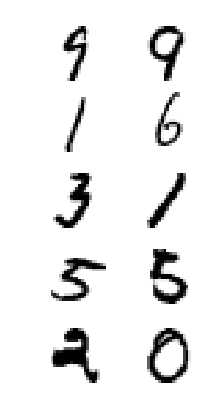

In [ ]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [ ]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

c.	Train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not.


In [ ]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

In [ ]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.69103277
0 Test accuracy: 0.542
1 Train loss: 0.6035354
2 Train loss: 0.54946035
3 Train loss: 0.47047246
4 Train loss: 0.4060757
5 Train loss: 0.38308156
5 Test accuracy: 0.824
6 Train loss: 0.39047274
7 Train loss: 0.3390794
8 Train loss: 0.3210671
9 Train loss: 0.31792685
10 Train loss: 0.24494292
10 Test accuracy: 0.8881
11 Train loss: 0.2929235
12 Train loss: 0.23225449
13 Train loss: 0.23180929
14 Train loss: 0.19877923
15 Train loss: 0.20065464
15 Test accuracy: 0.9203
16 Train loss: 0.19700499
17 Train loss: 0.18893136
18 Train loss: 0.19965452
19 Train loss: 0.24071647
20 Train loss: 0.18882024
20 Test accuracy: 0.9367
21 Train loss: 0.12419197
22 Train loss: 0.14013417
23 Train loss: 0.120789476
24 Train loss: 0.15721135
25 Train loss: 0.11507861
25 Test accuracy: 0.948
26 Train loss: 0.13891116
27 Train loss: 0.1526081
28 Train loss: 0.123436704
<<50 more lines>>
70 Test accuracy: 0.9743
71 Train loss: 0.019732744
72 Train loss: 0.039464083
73 Train loss: 0.0

d.	Now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class.

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(frozen_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9455
10 Test accuracy: 0.9634
20 Test accuracy: 0.9659
30 Test accuracy: 0.9656
40 Test accuracy: 0.9655
50 Test accuracy: 0.9656
60 Test accuracy: 0.9655
70 Test accuracy: 0.9656
80 Test accuracy: 0.9654
90 Test accuracy: 0.9654


In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8694
10 Test accuracy: 0.9276
20 Test accuracy: 0.9299
30 Test accuracy: 0.935
40 Test accuracy: 0.942
50 Test accuracy: 0.9435
60 Test accuracy: 0.9442
70 Test accuracy: 0.9447
80 Test accuracy: 0.9448
90 Test accuracy: 0.945
100 Test accuracy: 0.945
110 Test accuracy: 0.9458
120 Test accuracy: 0.9456
130 Test accuracy: 0.9458
140 Test accuracy: 0.9458
